# Aerial Image Classification
##### Matthew Peach

### Dataset: https://paperswithcode.com/dataset/aid

I'm going to try to train a CNN to categorize different aerial pictures. I only picked seven classes to use from the original dataset.

## Environment Setup

In [1]:
import os
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.image import imread

In [2]:
data_directory = ".//Aerial_Images//"
os.listdir(data_directory)

['Forest',
 'Parking',
 'Beach',
 'BareLand',
 'DenseResidential',
 'Commercial',
 'Meadow']

The above array contains the classes.

### Available Images
These are the number of images that I have to work with.

In [3]:
print("Forest:", len(os.listdir(data_directory + "Forest")))
print("Parking:", len(os.listdir(data_directory + "Parking")))
print("Beach:", len(os.listdir(data_directory + "Beach")))
print("BareLand:", len(os.listdir(data_directory + "BareLand")))
print("DenseResidential:", len(os.listdir(data_directory + "DenseResidential")))
print("Commercial:", len(os.listdir(data_directory + "Commercial")))
print("Meadow:", len(os.listdir(data_directory + "Meadow")))

Forest: 251
Parking: 390
Beach: 400
BareLand: 310
DenseResidential: 410
Commercial: 350
Meadow: 280


### Looking at Images

In [4]:
print(os.listdir(data_directory + "Commercial")[100])
print(type(os.listdir(data_directory + "Commercial")[100]))

commercial_340.jpg
<class 'str'>


They should all be the same shape.

In [5]:
exampleImage = data_directory + "Commercial//" + "commercial_340.jpg"
imread(exampleImage).shape

(600, 600, 3)

This is the pixel in the top left corner. These color values will need to be normalized from 0 - 255 to 0 - 1.

In [6]:
imread(exampleImage)[0][0]

array([100,  89,  83], dtype=uint8)

In [7]:
# Getting the maximum RGB value present in any pixel in the image
imread(exampleImage).max()

255

Here is one image from the "Commercial" class.

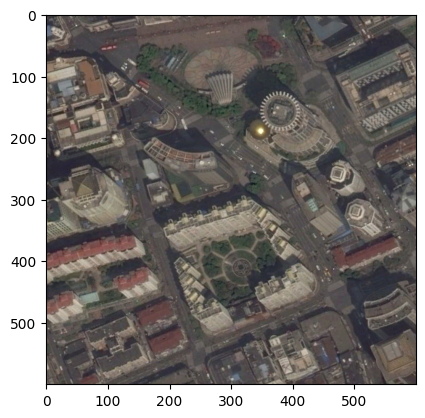

In [8]:
plt.imshow(imread(exampleImage))

## Using ImageDataGenerator

ImageDataGenerator will randomly transform images before they are fed into the CNN for training. I'm pretty sure it will do the random transformation differently every epoch. This should help the CNN "focus" on the most important features.

In [9]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

2023-10-15 20:42:24.547784: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [10]:
image_generator = ImageDataGenerator(rescale = 1/255,             # Rescale RGB values to 0 - 1
                                     rotation_range = 80,         # Rotate up to 80 degrees
                                     width_shift_range = 0.15,    # Shift images horizontally up to 15% of the image width
                                     height_shift_range = 0.15,   # Shift the images vertically up to 15% of the image height
                                     shear_range = 0.10,          # Distort the image along the x or y axis up to 10%
                                     zoom_range = 0.20,           # Zoom up to 20%
                                     horizontal_flip = True,      # Randomly horizontal flip
                                     fill_mode = "nearest",       # Fill in unknown pixel values with the value of their nearest pixel
                                     validation_split = 0.2)      # This will be used later for splitting train/test

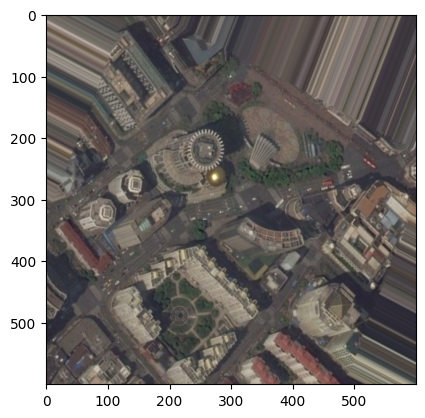

In [11]:
# Going to be easier to work with the image this way...
exampleImage = imread(exampleImage)

# The previous image transformed with image_generator
plt.imshow(image_generator.random_transform(exampleImage))

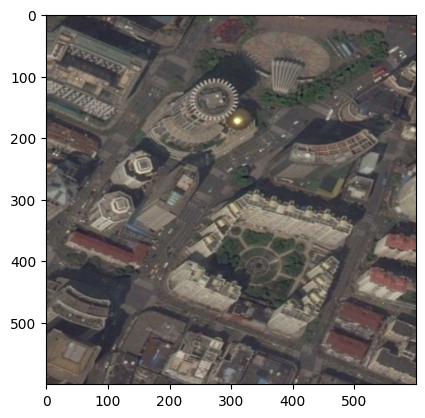

In [12]:
plt.imshow(image_generator.random_transform(exampleImage))

The images look very distorted, I worry this may result in the natural landscape images looking like they have structures in them. The "fill_mode = nearest" argument is making a lot of straight lines along the edges.

In [13]:
print(os.listdir(data_directory + "Forest")[0])

forest_166.jpg


Let's look at an undistorted forest image.

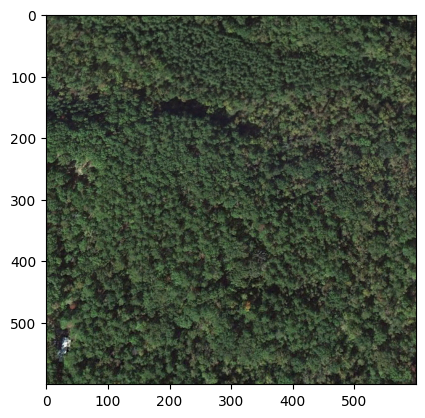

In [14]:
exampleForest = data_directory + "Forest//" + "forest_166.jpg"
exampleForest = imread(exampleForest)
plt.imshow(exampleForest)

Below is a distorted forest image.

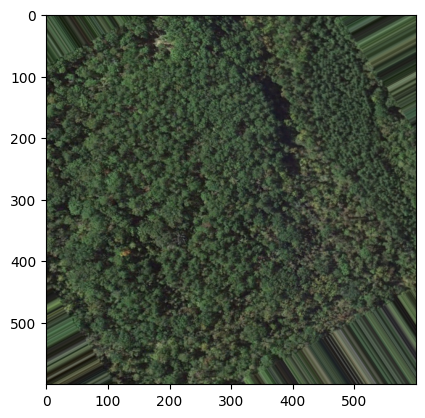

In [15]:
plt.imshow(image_generator.random_transform(exampleForest))

I can still tell this is a forest, but will the CNN? If the straight lines along edges show up in every class, they might effectively be "ignored". Color will also play a part in the CNNs decisions. I'm going to go forward with this amount of distortion.

## Splitting Train and Test data with ImageDataGenerator

In [16]:
%%time
BATCH_SIZE = 8

train_data = image_generator.flow_from_directory(directory = data_directory,
                                                 target_size = (600, 600),     # All images are 600x600
                                                 color_mode = "rgb",           # Pixels are RGB
                                                 batch_size = BATCH_SIZE, 
                                                 class_mode = "categorical",   # One-hot encode labels
                                                 subset = "training", 
                                                 seed = 93)

validation_data = image_generator.flow_from_directory(directory = data_directory,
                                                      target_size = (600, 600), 
                                                      color_mode = "rgb", 
                                                      batch_size = BATCH_SIZE, 
                                                      class_mode = "categorical", 
                                                      subset = "validation",
                                                      seed = 93, 
                                                      shuffle = False)

Found 1913 images belonging to 7 classes.
Found 478 images belonging to 7 classes.
CPU times: user 165 ms, sys: 319 ms, total: 484 ms
Wall time: 357 ms


## Class codes

In [17]:
type(train_data)

keras.src.preprocessing.image.DirectoryIterator

In [18]:
train_data.class_indices

{'BareLand': 0,
 'Beach': 1,
 'Commercial': 2,
 'DenseResidential': 3,
 'Forest': 4,
 'Meadow': 5,
 'Parking': 6}

Ok, these seem out of order because...

In [19]:
os.listdir(data_directory)

['Forest',
 'Parking',
 'Beach',
 'BareLand',
 'DenseResidential',
 'Commercial',
 'Meadow']

... puts "Forest" first, but "BareLand" is encoded as 0. I found out why after reading the documentation for flow_from_directory again. I didn't use an argument for "classes":

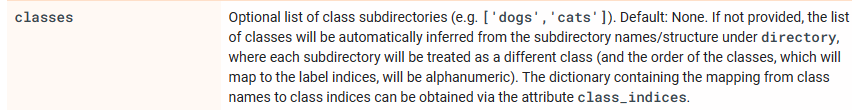

What's also interesting is that the class_mode argument "categorical" one-hot encodes the classes, but class_indicies automatically converts binary to decimal.

## The Model

I use a Pooling layer after every Convolutional layer although I know you don't *have* to do that, but it's standard. I also can't use many more nodes than what I've done below because I begin to get errors about memory usage.

In [20]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, MaxPool2D, Dropout, Flatten

In [21]:
%%time

model = Sequential()

# Strides parameter default to (1,1)

model.add(Conv2D(filters = 32, 
                 kernel_size = (3,3), 
                 input_shape = (600, 600, 3), 
                 activation = "relu"))

model.add(MaxPool2D(pool_size = (2,2)))


model.add(Conv2D(filters = 32, 
                 kernel_size = (3,3), 
                 input_shape = (600, 600, 3), 
                 activation = "relu"))

model.add(MaxPool2D(pool_size = (2,2)))

model.add(Conv2D(filters = 32, 
                 kernel_size = (3,3), 
                 input_shape = (600, 600, 3), 
                 activation = "relu"))

model.add(MaxPool2D(pool_size = (2,2)))

model.add(Conv2D(filters = 16, 
                 kernel_size = (3,3), 
                 input_shape = (600, 600, 3), 
                 activation = "relu"))

model.add(MaxPool2D(pool_size = (2,2)))


model.add(Flatten())
model.add(Dense(64, activation = "relu"))
model.add(Dropout(0.25))

# One output neuron per class
model.add(Dense(7, activation = "softmax"))

2023-10-15 20:42:28.280345: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] could not open file to read NUMA node: /sys/bus/pci/devices/0000:65:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-10-15 20:42:28.288191: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] could not open file to read NUMA node: /sys/bus/pci/devices/0000:65:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-10-15 20:42:28.288493: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] could not open file to read NUMA node: /sys/bus/pci/devices/0000:65:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-10-15 20:42:28.293455: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] could not open file to read NUMA node: /sys/bus/pci/devices/0000:65:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-10-15 20:42:28.293725: I tensorflow/compile

CPU times: user 706 ms, sys: 570 ms, total: 1.28 s
Wall time: 2.5 s


Categorical crossentropy for multi-class classification.
Adam and accuracy because they are standard.

In [22]:
%%time
model.compile(loss = "categorical_crossentropy", 
              optimizer = "adam", 
              metrics = ["accuracy"])

CPU times: user 5.59 ms, sys: 7.09 ms, total: 12.7 ms
Wall time: 11.3 ms


In [23]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 598, 598, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2  (None, 299, 299, 32)      0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 297, 297, 32)      9248      
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 148, 148, 32)      0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 146, 146, 32)      9248      
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 73, 73, 32)        0

Early stopping if val_loss increases for 3 epochs. If val_loss starts going up while accuracy is also increasing then the model would be overfitting.

In [24]:
from tensorflow.keras.callbacks import EarlyStopping
# Implementing early stopping
early_stop = EarlyStopping(monitor = "val_loss", patience = 3)

## Training

In [25]:
%%time

results = model.fit(train_data, 
                    epochs = 20, 
                    validation_data = validation_data, 
                    callbacks = [early_stop])

Epoch 1/20


2023-10-15 20:42:33.539110: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:432] Loaded cuDNN version 8600
2023-10-15 20:42:34.576250: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x7f11b3ce6b10 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2023-10-15 20:42:34.576309: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA GeForce RTX 2080 Ti, Compute Capability 7.5
2023-10-15 20:42:34.582233: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:255] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2023-10-15 20:42:34.705602: I ./tensorflow/compiler/jit/device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


240/240 [==============================] - 190s 774ms/step - loss: 1.6742 - accuracy: 0.2995 - val_loss: 1.1774 - val_accuracy: 0.6130
Epoch 2/20
240/240 [==============================] - 185s 772ms/step - loss: 1.1441 - accuracy: 0.5525 - val_loss: 0.8170 - val_accuracy: 0.6841
Epoch 3/20
240/240 [==============================] - 185s 770ms/step - loss: 0.8205 - accuracy: 0.6905 - val_loss: 0.7847 - val_accuracy: 0.7218
Epoch 4/20
240/240 [==============================] - 187s 780ms/step - loss: 0.7774 - accuracy: 0.6984 - val_loss: 0.5929 - val_accuracy: 0.7531
Epoch 5/20
240/240 [==============================] - 186s 773ms/step - loss: 0.6782 - accuracy: 0.7517 - val_loss: 1.0189 - val_accuracy: 0.6151
Epoch 6/20
240/240 [==============================] - 187s 780ms/step - loss: 0.6179 - accuracy: 0.7710 - val_loss: 0.4834 - val_accuracy: 0.8347
Epoch 7/20
240/240 [==============================] - 188s 784ms/step - loss: 0.6083 - accuracy: 0.7883 - val_loss: 0.6012 - val_accura

#### Note: Ended early because val_loss began to increase

## Model Evaluation

In [26]:
model.metrics_names

['loss', 'accuracy']

In [27]:
metrics = pd.DataFrame(model.history.history)

In [28]:
metrics.describe

<bound method NDFrame.describe of         loss  accuracy  val_loss  val_accuracy
0   1.674195  0.299530  1.177400      0.612971
1   1.144135  0.552535  0.816963      0.684100
2   0.820521  0.690538  0.784689      0.721757
3   0.777370  0.698380  0.592908      0.753138
4   0.678218  0.751699  1.018887      0.615063
5   0.617926  0.771040  0.483448      0.834728
6   0.608285  0.788291  0.601163      0.811715
7   0.562810  0.800836  0.464754      0.857741
8   0.524096  0.808155  0.570196      0.717573
9   0.501754  0.822791  0.649762      0.801255
10  0.466291  0.833246  0.673173      0.782427>

<Axes: >

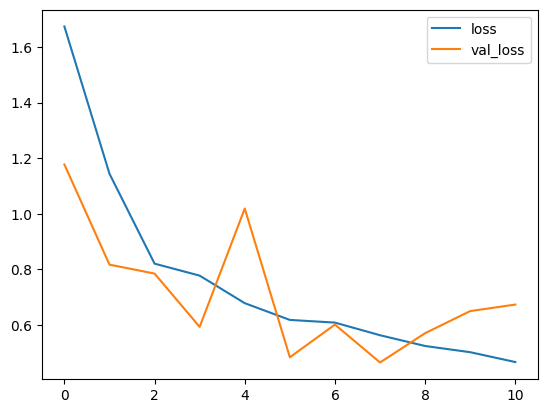

In [29]:
metrics[["loss", "val_loss"]].plot()

<Axes: >

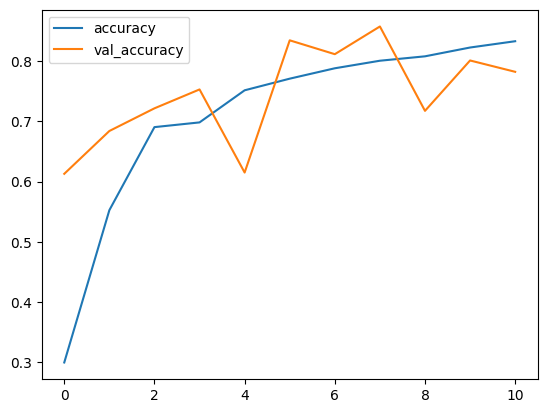

In [30]:
metrics[["accuracy", "val_accuracy"]].plot()

In [31]:
%%time
pred_probs = model.predict(validation_data)

60/60 [==============================] - 40s 658ms/step
CPU times: user 41.8 s, sys: 1.75 s, total: 43.5 s
Wall time: 40.3 s


In [32]:
from sklearn.metrics import classification_report, confusion_matrix

# Get the predicted class instead of an array of all prediction values for every class of every image
predictions = np.argmax(pred_probs, axis = 1)

In [33]:
print(classification_report(validation_data.classes, predictions))

              precision    recall  f1-score   support

           0       0.90      0.92      0.91        62
           1       0.92      0.84      0.88        80
           2       0.84      0.23      0.36        70
           3       0.59      0.98      0.73        82
           4       0.61      0.98      0.75        50
           5       0.88      0.50      0.64        56
           6       1.00      0.96      0.98        78

    accuracy                           0.78       478
   macro avg       0.82      0.77      0.75       478
weighted avg       0.82      0.78      0.76       478



<Axes: >

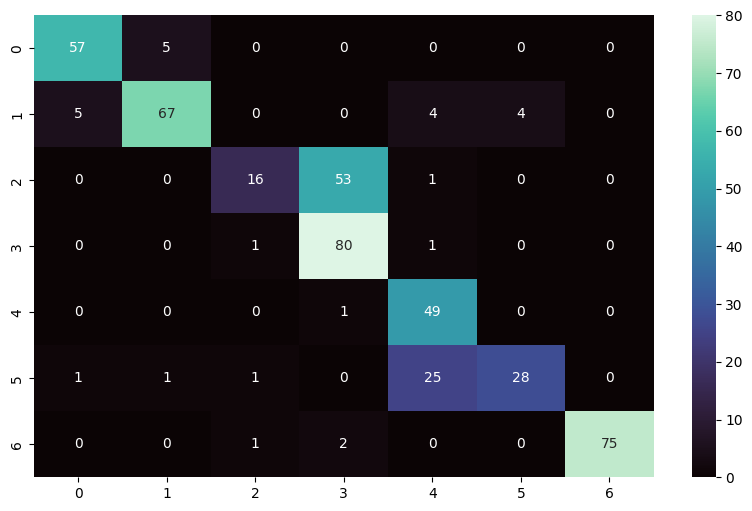

In [34]:
plt.figure(figsize = (10,6))
sns.heatmap(confusion_matrix(validation_data.classes, predictions), annot = True, cmap = "mako")

In [35]:
train_data.class_indices

{'BareLand': 0,
 'Beach': 1,
 'Commercial': 2,
 'DenseResidential': 3,
 'Forest': 4,
 'Meadow': 5,
 'Parking': 6}

#### Class indicies above to interpret the Confusion Matrix

## Final Thoughts/Observations

I didn't expect the model to turn out so well! The biggest problems with the model is the difficulty in differentiating DenseResidential and Commercial, which makes sense because they're both building-heavy images. It's interesting how val_accuracy and val_loss "jump" up and down near the end of the training. Maybe I should try again with less or 0 dropout (I used 25%); I wonder if that can cause too much variation. Accounting for variation is why I used a patience of 3, I ran this model a few times before using a patience of 2 and it would end very early sometimes.